In [323]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

import torch
import torch.nn as nn
from torch.optim import Adam

from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges

from torch_geometric.nn.models import InnerProductDecoder, VGAE
from torch_geometric.nn.conv import GCNConv
from torch_geometric.nn import knn_graph
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops


# def Fisher_distz_vectorized(z1, z2):
#     dim = z1.shape[1] // 2
#     mu1, sigma1 = z1[:, :dim], torch.exp(z1[:, dim:]/2)
#     mu2, sigma2 = z2[:, :dim], torch.exp(z2[:, dim:]/2)

#     diff = (mu1 - mu2) / torch.sqrt(torch.tensor(2.0))
#     s1_plus_s2 = sigma1 + sigma2
#     s1_minus_s2 = sigma1 - sigma2

#     a = torch.sqrt(diff**2 + s1_plus_s2**2 + 1e-15) + torch.sqrt(diff**2 + s1_minus_s2**2 + 1e-15)
#     b = torch.sqrt(diff**2 + s1_plus_s2**2 + 1e-15) - torch.sqrt(diff**2 + s1_minus_s2**2 + 1e-15)

#     dF2 = 2 * (torch.log((a+1e-15) / (b+1e-15)))**2
#     dF = torch.sqrt(dF2.sum(dim=1) + 1e-15)
#     if dF.isnan().sum().item():
#         print(a,b,dF2)
#     return dF

def Fisher_distz_vectorized(z1, z2):
    dim = z1.shape[1] // 2
    mu1, sigma1 = z1[:, :dim], torch.exp(z1[:, dim:]/2)
    mu2, sigma2 = z2[:, :dim], torch.exp(z2[:, dim:]/2)

    diff_ij = mu1 - mu2
    ss_ij = sigma1 + sigma2
    ds_ij = sigma1 - sigma2
    # print(sigma1,sigma2)

    
    dF2 = 2*((torch.log (
        
        (torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)+torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)/\
        (torch.abs((torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)-torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)
        +1e-10)+1e-10)
            +1e-10))**2).sum(axis=-1)
    # print(dF2)
    
    return torch.sqrt(dF2)

class FisherDecoder(torch.nn.Module):
    def forward(self, z, edge_index, sigmoid: bool = True):
        """Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        z1 = z[edge_index[0]]
        z2 = z[edge_index[1]]
        
        value = Fisher_distz_vectorized(z1, z2)
        return torch.sigmoid(-torch.log(value + 1e-15)) if sigmoid else torch.exp(-value)
    
    def forward_all(self, z, sigmoid = True):
        """Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """

        z1 = z.unsqueeze(1)  # Shape: (N, 1, D)
        z2 = z.unsqueeze(0)  # Shape: (1, N, D)
        dim = z.shape[1] // 2
        mu1, sigma1 = z1[:, :, :dim], torch.exp(z1[:, :, dim:]/2)
        mu2, sigma2 = z2[:, :, :dim], torch.exp(z2[:, :, dim:]/2)

        diff_ij = mu1 - mu2
        ss_ij = sigma1 + sigma2
        ds_ij = sigma1 - sigma2

        
        dF2 = 2*((torch.log (
            
            (torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)+torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)/\
            (torch.abs((torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)-torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)
            +1e-10)+1e-10)
                +1e-10))**2).sum(axis=-1)   
        
        # Compute Fisher distance for all pairs
        value = torch.sqrt(dF2)
        return torch.sigmoid(-torch.log(value + 1e-15)) if sigmoid else torch.exp(-value)


class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.gcn_mu = GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = GCNConv(hidden_channels, out_channels)
        self.linear_mu = nn.Linear(hidden_channels, out_channels)
        self.linear_logvar = nn.Linear(hidden_channels, out_channels)
        ###################initialize

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        # mu = self.linear_mu(x)
        # logvar = self.linear_logvar(x)
        
        return mu, logvar


# class DeepVGAE(VGAE):
#     def __init__(self, enc_in_channels, enc_hidden_channels, enc_out_channels,decoder=InnerProductDecoder()):
#         super(DeepVGAE, self).__init__(encoder=GCNEncoder(enc_in_channels,
#                                                           enc_hidden_channels,
#                                                           enc_out_channels),
#                                        decoder=decoder)

#     def forward(self, x, edge_index):
#         z = self.encode(x, edge_index)
#         adj_pred = self.decoder.forward_all(z)
#         return adj_pred

#     def loss(self, x, pos_edge_index, all_edge_index):
#         z = self.encode(x, pos_edge_index)

#         pos_loss = -torch.log(
#             self.decoder(z, pos_edge_index, sigmoid=True) + 1e-15).mean()

#         # Do not include self-loops in negative samples
#         all_edge_index_tmp, _ = remove_self_loops(all_edge_index)
#         all_edge_index_tmp, _ = add_self_loops(all_edge_index_tmp)

#         neg_edge_index = negative_sampling(all_edge_index_tmp, z.size(0), pos_edge_index.size(1))
#         neg_loss = -torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + 1e-15).mean()

#         kl_loss = 1 / x.size(0) * self.kl_loss()

#         return pos_loss + neg_loss + kl_loss

#     def single_test(self, x, train_pos_edge_index, test_pos_edge_index, test_neg_edge_index):
#         with torch.no_grad():
#             z = self.encode(x, train_pos_edge_index)
#         roc_auc_score, average_precision_score = self.test(z, test_pos_edge_index, test_neg_edge_index)
#         return roc_auc_score, average_precision_score

class FisherVGAE(VGAE):
    def __init__(self, enc_in_channels, enc_hidden_channels, enc_out_channels,decoder=FisherDecoder()):
        super(FisherVGAE, self).__init__(encoder=GCNEncoder(enc_in_channels,
                                                          enc_hidden_channels,
                                                          enc_out_channels),
                                       decoder=decoder)

    def forward(self, x, edge_index):
        mu, logvar = self.encoder.forward(x, edge_index)
        z = torch.cat((mu, logvar), dim=1)
        adj_pred = self.decoder.forward_all(z)
        return adj_pred

    def loss(self, x, pos_edge_index, all_edge_index):
        mu, logvar = self.encoder.forward(x, pos_edge_index)
        z = torch.cat((mu, logvar), dim=1)

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index) + 1e-15).mean()

        # Do not include self-loops in negative samples
        all_edge_index_tmp, _ = remove_self_loops(all_edge_index)
        # all_edge_index_tmp, _ = add_self_loops(all_edge_index_tmp)

        neg_edge_index = negative_sampling(all_edge_index_tmp, z.size(0), pos_edge_index.size(1))
        neg_loss = -torch.log(1 - self.decoder(z, neg_edge_index) + 1e-15).mean()

        kl_loss = -0.5 * torch.mean(
            torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1))
    
        # kl_loss = 1 / x.size(0) * kl_loss

        return pos_loss + neg_loss + 0.2*kl_loss
        # return kl_loss

    def single_test(self, x, train_pos_edge_index, test_pos_edge_index, test_neg_edge_index):
        with torch.no_grad():
            mu, logvar = self.encoder.forward(x, train_pos_edge_index)
            z = torch.cat((mu, logvar), dim=1)
        roc_auc_score, average_precision_score = self.test(z, test_pos_edge_index, test_neg_edge_index)
        return roc_auc_score, average_precision_score

In [324]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs("datasets", exist_ok=True)

## Cora Datasets##
# dataset = Planetoid("datasets", 'Cora', transform=T.NormalizeFeatures())
# data = dataset[0].to(device)

In [325]:
# Toy Random
# # 随机初始化节点特征
# x = torch.randn((num_nodes, num_features))

# # 随机生成边
# edge_index = torch.tensor(np.random.randint(0, num_nodes, (2, 500)), dtype=torch.long)

# # 创建数据对象并分割边
# data = Data(x=x, edge_index=edge_index)

In [326]:
# Toy Saddle
#######################################################
num_nodes = 5000  # 节点数量

# 随机初始化节点特征
data_name = 'saddle'
n_samples=5000
X_minor=0.1*np.random.randn(n_samples,7)

roi=np.linspace(-5,5,10000)

x1=np.random.choice(roi,n_samples)
x2=np.random.choice(roi,n_samples)

x3=1*((x1)**2 - (x2)**2)


X_major=np.array([x1,x2,x3]).T
X=np.hstack((X_major,X_minor))

from g2g_model_Fisher import *
k_nei = 10
L = 3
A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)
# A=radius_neighbors_graph(X,3,include_self=True)
X_major = X[:,:3]

row =np.array([np.ones((k_nei,))*i for i in range(n_samples)]).flatten()
col=A.indices
w_val=np.array([np.linalg.norm(X_major[int(i),:]-X_major[int(j),:]) for i,j in zip(row,col)])
dc=np.mean(w_val)

cell_nei=A.indices.reshape(X.shape[0],10)
nei_w=[]
rho_arr=[]
for ni in cell_nei:
    dij=np.array([np.linalg.norm(X_major[int(ni[0]),:]-X_major[int(i),:]) for i in ni[1:]])
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

# 生成 KNN 图
A_coo = A.tocoo()
row = torch.tensor(A_coo.row, dtype=torch.long)
col = torch.tensor(A_coo.col, dtype=torch.long)
edge_index = torch.cat([torch.stack([row, col], dim=0), torch.stack([col, row], dim=0)], dim=1)

data = Data(x=torch.from_numpy(X).float(), edge_index=edge_index)
########################################################

In [327]:
# Toy Ellipsoid
##############################################333333
# n_samples=4000

# x1 = np.random.uniform(-1,1,n_samples)
# x2 = np.random.uniform(-4,4,n_samples)
# idx = (x1**2+x2**2/16 < 1)
# x1 = x1[idx]
# x2 = x2[idx]
# n_samples = len(x2)

# x3 = np.random.choice(np.array([-1,1]),n_samples)*np.sqrt(1-x1**2-x2**2/16)

# X_major=np.array([x1,x2,x3]).T
# X_minor=0.2*np.random.randn(n_samples,7)
# X=np.hstack((X_major,X_minor))

# from g2g_model_Fisher import *
# k_nei = 10
# L = 3
# A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)
# # A=radius_neighbors_graph(X,3,include_self=True)
# X_major = X[:,:3]

# row =np.array([np.ones((k_nei,))*i for i in range(n_samples)]).flatten()
# col=A.indices
# w_val=np.array([np.linalg.norm(X_major[int(i),:]-X_major[int(j),:]) for i,j in zip(row,col)])
# dc=np.mean(w_val)

# cell_nei=A.indices.reshape(X.shape[0],k_nei)
# nei_w=[]
# rho_arr=[]
# for ni in cell_nei:
#     dij=np.array([np.linalg.norm(X_major[int(ni[0]),:]-X_major[int(i),:]) for i in ni[1:]])
#     rho=np.sum(np.exp(-dij**2/dc**2))
# #     rho=np.exp(np.sum(-dij**2/dc**2))
#     nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
# #     print(dij)
# #     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     rho_arr.append(rho)
# rho_arr=np.array(rho_arr)/np.amax(rho_arr)
# nei_w=np.array(nei_w)
# nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

# # 生成 KNN 图
# A_coo = A.tocoo()
# row = torch.tensor(A_coo.row, dtype=torch.long)
# col = torch.tensor(A_coo.col, dtype=torch.long)
# edge_index = torch.cat([torch.stack([row, col], dim=0), torch.stack([col, row], dim=0)], dim=1)

# data = Data(x=torch.from_numpy(X).float(), edge_index=edge_index)
########################################################

In [339]:
import scvelo as scv
import matplotlib.pyplot as plt
## DG Data
############################################
data_path = 'data/'
data_name = 'EG_bin_ppt'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
# data_name = 'zebrafish_dynamo_part'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
[k_nei, K, L] = [30, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'
cmap = plt.colormaps['Spectral_r']

import scanpy as sc
from scipy.sparse import csr_matrix, identity
adata=adata0.copy()
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
cell_vpt = adata.obs['palantir_pseudotime'].values#adata0.obs['latent_time'].values#
# cell_vpt = adata.obs['ct_pseudotime'].values
# cell_ppt = adata.obs['palantir_pseudotime'].values
Xs = adata.layers['Ms']#adata.X.A#
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])

cell_nei=col.reshape([-1,k_nei])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

A = A_mat
A_coo = (A-identity(X.shape[0], format='csr')).tocoo() 
row = torch.tensor(A_coo.row, dtype=torch.long)
col = torch.tensor(A_coo.col, dtype=torch.long)
edge_index = torch.cat([torch.stack([row, col], dim=0), torch.stack([col, row], dim=0)], dim=1)

data = Data(x=torch.from_numpy(X).float(), edge_index=edge_index)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [340]:
# Cora Datasets##
# dataset = Planetoid("datasets", 'Cora', transform=T.NormalizeFeatures())
# data = dataset[0].to(device)

torch.manual_seed(0)
all_edge_index = data.edge_index
data = train_test_split_edges(data, 0.05, 0.1)

model = FisherVGAE(data.x.shape[1],32,L, decoder = FisherDecoder()).to(device)
optimizer = Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    loss = model.loss(data.x, data.train_pos_edge_index, all_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        model.eval()
        roc_auc, ap = model.single_test(data.x,
                                        data.train_pos_edge_index,
                                        data.test_pos_edge_index,
                                        data.test_neg_edge_index)
        print("Epoch {} - Loss: {} ROC_AUC: {} Precision: {}".format(epoch, loss.cpu().item(), roc_auc, ap))

Epoch 0 - Loss: 6.038250923156738 ROC_AUC: 0.7706919136107974 Precision: 0.7794907591737967
Epoch 1 - Loss: 4.849386215209961 ROC_AUC: 0.8542853026414966 Precision: 0.8328175853576609
Epoch 2 - Loss: 2.1079461574554443 ROC_AUC: 0.8614396008690298 Precision: 0.8324507798814598
Epoch 3 - Loss: 1.6713390350341797 ROC_AUC: 0.8484571353701911 Precision: 0.8201886574545447
Epoch 4 - Loss: 1.8468165397644043 ROC_AUC: 0.8412557587886443 Precision: 0.8187516063945518
Epoch 5 - Loss: 1.698765754699707 ROC_AUC: 0.8752040666350688 Precision: 0.8508441728410023
Epoch 6 - Loss: 1.373451828956604 ROC_AUC: 0.8819044626492386 Precision: 0.8521583872175611
Epoch 7 - Loss: 1.2662535905838013 ROC_AUC: 0.8801145988263489 Precision: 0.8505236937256748
Epoch 8 - Loss: 1.2500953674316406 ROC_AUC: 0.8878679827064304 Precision: 0.8586875497288112
Epoch 9 - Loss: 1.2405716180801392 ROC_AUC: 0.893182538632453 Precision: 0.8627330708775844
Epoch 10 - Loss: 1.2169994115829468 ROC_AUC: 0.9043246373415593 Precision: 

In [341]:
# def batch_edges(edge_index, batch_size):
#     num_edges = edge_index.size(1)
#     for i in range(0, num_edges, batch_size):
#         yield edge_index[:, i:i + batch_size]

# # VGAE 训练循环
# batch_size = 100
# epochs = 200

# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()

#     for batch_edge_index in batch_edges(data.train_pos_edge_index, batch_size):
#         z = model.encode(data.x, batch_edge_index)
#         loss = model.recon_loss(z, batch_edge_index)
#         loss.backward()
#         optimizer.step()
#         if epoch % 1 == 0:
#             model.eval()
#             roc_auc, ap = model.single_test(data.x,
#                                             data.train_pos_edge_index,
#                                             data.test_pos_edge_index,
#                                             data.test_neg_edge_index)
#             print("Epoch {} - Loss: {} ROC_AUC: {} Precision: {}".format(epoch, loss.cpu().item(), roc_auc, ap))

In [342]:
# model.eval()
# z = model.encode(data.x, all_edge_index)
# p = torch.sigmoid(torch.matmul(z, z.t()))
# cut = p.flatten().detach().sort(descending=True).values[k_nei*data.x.shape[0]]
# cut

In [343]:
# model.eval()
# mu, logvar = model.encoder.forward(data.x, all_edge_index)
# z = torch.cat((mu,logvar),dim=1)
# p = FisherDecoder().forward_all(z)
# cut = p.flatten().detach().sort(descending=True).values[(k_nei-1)*data.x.shape[0]]
# cut

In [344]:
# adj = p > cut
# adj = adj.int()
# adj.sum(),torch.tensor(A_coo.todense(), dtype=int).sum(),(torch.tensor(A_coo.todense(), dtype=int) - adj).sum()

In [345]:
# torch.abs(torch.tensor(A_coo.todense(), dtype=int) - adj).sum()

## **Try model** ##

In [346]:
all_edge_index

tensor([[   0,    0,    0,  ..., 1564, 1666, 1668],
        [  33,   83,  104,  ..., 1717, 1717, 1717]])

In [347]:
mu, logvar = model.encoder.forward(data.x, all_edge_index)
mu_learned = mu.detach().numpy()
sigma_learned = torch.exp(logvar/2).detach().numpy()


Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

In [348]:
from g2g_model_Fisher import *
from utils import *
from scipy.sparse import csr_matrix, identity

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2+1e-12)
    return W_dist

cRc_arr=[]
cRc_arr_eu=[]
A = csr_matrix(A + np.eye(A.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc)

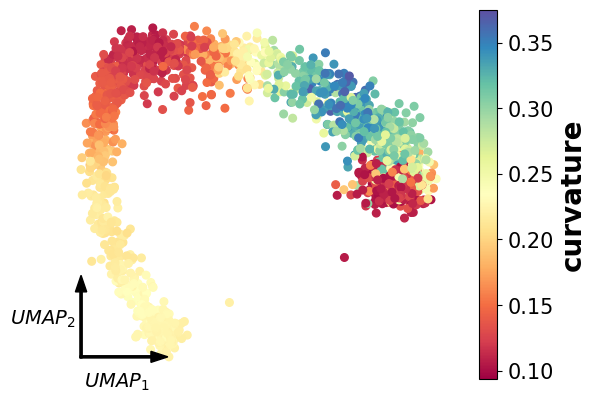

In [350]:
# X_umap = adata.obsm['X_umap']
# X_plt = X_umap[:,0]
# Y_plt = X_umap[:,1]

X_plt = X_pca[:,0]
Y_plt = X_pca[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min
Y_ori = Y_min

idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
plt.axis('off')

clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*17,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')


plt.show()